In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

#insert path
sys.path.insert(0, '../methods/')

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARWQE', None)
from ARWQE import *

sys.modules.pop('plots', None)
from plots import *

sys.modules.pop('ARWME', None)
from ARWME import *

In [165]:
# ELEC2 data set
# downloaded from https://www.kaggle.com/yashsharan/the-elec2-dataset
data = pd.read_csv('electricity-normalized.csv')
col_names = data.columns
data = data.to_numpy()

# remove the first stretch of time where 'transfer' does not vary
data = data[17760:]

# set up variables for the task (predicting 'transfer')
covariate_col = ['nswprice', 'nswdemand', 'vicprice', 'vicdemand']
response_col = 'transfer'
# keep data points for 9:00am - 12:00pm
keep_rows = np.where((data[:,2]>data[17,2])&(data[:,2]<data[24,2]))[0]

X = data[keep_rows][:,np.where([t in covariate_col for t in col_names])[0]]
Y = data[keep_rows][:,np.where(col_names==response_col)[0]].flatten()
X = X.astype('float64')
Y = Y.astype('float64')

N = X.shape[0]; p = X.shape[1]; alpha = 0.1
train_lag = 100 # start predicting after train_lag many observations

In [167]:
alpha =0.1; delta = 0.1; gamma=1
num_periods = X.shape[0]
print(num_periods)
np.random.seed(6)
B_arr = np.ones(num_periods)

3444


In [191]:
num_trials = 1
train_lag = 100
N = len(Y)
fixed_windows = [1, 4, 16, 64, 256, 1024, 4096]
cdf_dict = create_empty_dict(fixed_windows, num_trials)
interval_dict = create_empty_dict(fixed_windows, num_trials)

seeds = np.arange(num_trials) + 2024

for (trial, seed) in enumerate(seeds):
    
    np.random.seed(seed)

    k_hat_all = []

    for t in tqdm(range(train_lag, N)):

        inds_odd = np.arange(1,int(np.ceil(t/2)*2-1),2)
        inds_even = np.arange(2,int(np.floor(t/2)*2),2)
        
        X_tr = X[:t, :][inds_odd]; Y_tr = Y[:t][inds_odd]
        X_val = X[:t, :][inds_even]; Y_val = Y[:t][inds_even]
        X_test = X[t]; Y_test = Y[t]

        #TODO: choose a fixed training window
        #reg, S_t = fit_and_get_scores(X_tr_t, Y_tr_t, X_val_t, Y_val_t)

        beta_hat, S_t = fit_LS_get_scores(X_tr, Y_tr, X_val, Y_val)

        B_val_t = np.ones(len(Y_val)).astype(int)

        khat, qt_khat, qtk_all = ARWQE(S_t, B_val_t, alpha, delta, gamma)
        k_hat_all.append(khat)

        #compute prediction set on the next training point
        #y_hat = reg.predict(X_test.reshape(1,-1))
        y_hat = X_test.T.dot(beta_hat)
        coverage_ARW = check_coverage(y_hat, qt_khat, Y_test)
        #cdf_dict['ARW'][trial].append(coverage_ARW[0])
        cdf_dict['ARW'][trial].append(coverage_ARW)
        interval_dict['ARW'][trial].append(2*qt_khat)

        #baseline: take quantile of fixed k
        for ik, k in enumerate(fixed_windows):
            log2k = int(np.log2(k))
            qtk = qtk_all[min(log2k, len(qtk_all)-1)]
            coverage_k = check_coverage(y_hat, qtk, Y_test)
            #cdf_dict[f'Val_{k}'][trial].append(coverage_k[0])
            cdf_dict[f'Val_{k}'][trial].append(coverage_k)
            interval_dict[f'Val_{k}'][trial].append(2*qtk)

    #plot k_hat_all
    #plt.plot(k_hat_all)

100%|██████████| 3344/3344 [00:02<00:00, 1284.82it/s]


In [169]:
def fit_LS_get_scores(X_tr, Y_tr, X_val, Y_val):
    beta_hat = np.linalg.solve(X_tr.T.dot(X_tr), X_tr.T.dot(Y_tr))
    S = np.abs(X_val.dot(beta_hat) - Y_val)
    return beta_hat, S

In [200]:
arw_cov = np.array(cdf_dict['ARW'][0])
#change boolean to 0/1
arw_cov = arw_cov.astype(int)
print(arw_cov)

B_arr = np.ones(len(arw_cov)).astype(int)
smoothed_cov = np.zeros(len(arw_cov))
for t in tqdm(range(len(arw_cov))):
    khat, s = ARWME(arw_cov[:t+1], B_arr[:t+1], delta = 0.1, M = 1)
    smoothed_cov[t] = s
#plt.plot(smoothed_cov)

[1 1 1 ... 1 1 1]


100%|██████████| 3344/3344 [00:52<00:00, 63.46it/s]


0.06438884041429391


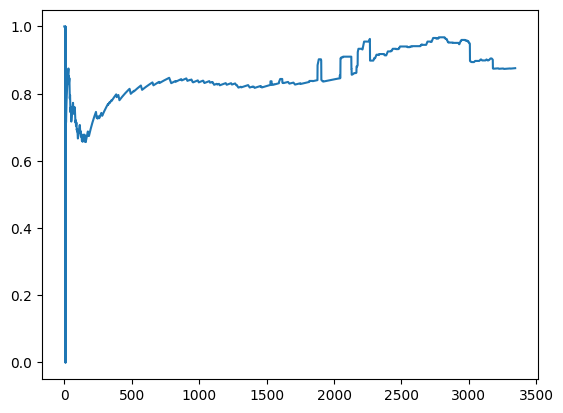

In [204]:
plt.plot(smoothed_cov)
mae = np.mean(np.abs(smoothed_cov - (1-alpha))[100:])
print(mae)

ARW 0.8819358816276203
Val_1 0.4707151664611591
Val_4 0.7364364981504316
Val_16 0.8193588162762022
Val_64 0.8736128236744759
Val_256 0.8628236744759556
Val_1024 0.8588162762022195
Val_4096 0.8529593094944513
ARW 0.5998825395654243
Val_1 0.287434208909371
Val_4 0.4248460792219763
Val_16 0.5517287812484207
Val_64 0.5755134684196269
Val_256 0.5666502840973587
Val_1024 0.5741493623842653
Val_4096 0.5601995838438764


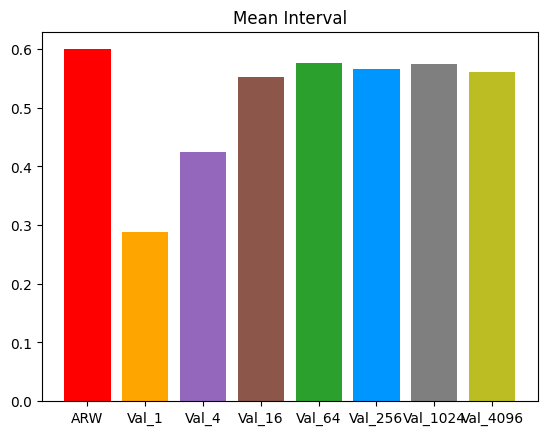

In [173]:
#process results in cdf_dict
methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
cov_array = np.zeros((len(methods), N-train_lag))
interval_array = np.zeros((len(methods), N-train_lag))

for i, method in enumerate(methods):
    cov_array[i, :] = np.array(cdf_dict[method][0])
    interval_array[i, :] = np.array(interval_dict[method][0])
    print(method, cov_array[i][100:].mean())

colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', 'tab:gray', 'tab:olive']
fig, ax = plt.subplots()
plt.title('Mean Interval')
for i in range(len(methods)):
    print(methods[i], interval_array[i].mean())
    ax.bar(methods[i], interval_array[i].mean(), color=colors[i])